# License

***

Copyright 2018 Lingyao Meng (danielle@h2o.ai), J. Patrick Hall (phall@h2o.ai), and the H2O.ai team. 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Imports and Setup

***

In [1]:
import os
import time
import sys
import re
import subprocess

# in-notebook display
from IPython.display import Image
from IPython.display import display

from data_maker_and_getter import DataMakerAndGetter
import eli5
import eli5.xgboost
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree
from h2o.backend import H2OLocalServer                            # for plotting local tree in-notebook
from lime_explainer import LIMEExplainer
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt
import pandas as pd
import shap
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
%matplotlib inline

In [3]:
# load JS visualization code to notebook
shap.initjs() 

In [4]:
h2o.init(max_mem_size='12G')
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 min 02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.4
H2O cluster version age:,1 month and 20 days
H2O cluster name:,H2O_from_python_patrickh_qai14m
H2O cluster total nodes:,1
H2O cluster free memory:,10.56 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


# Known Signal Generating Function

***

The objective of this notebook is to test and compare local explanations created by the popular methods: LIME, Treeinterpreter, and Shapley on an XGBoost model trained on a known signal generating function: 

$$y = x_1 * x_4 + |x_8| * (x_9)^2$$

In this notebook we allow XGBoost to train until it has a very exact fit to the dataset containing the signal generating function.

# Data Generation and XGBoost Training
***

In [5]:
ds_ = DataMakerAndGetter(nrows=200000, target='binary', one_function = True)
rsotrain = ds_.make_random_with_signal()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
y = 'target'
X = [name for name in rsotrain.columns if name not in [y,'row_id','function','cat1','cat2','cat3']]
print(X)

['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12']


In [7]:
rsotrain[y] = rsotrain[y].asfactor()

In [8]:
rsotrain_pd = rsotrain.as_data_frame()

In [9]:
rsotrain_dm = xgb.DMatrix(rsotrain_pd[X],
                          rsotrain_pd[y])

In [10]:
ave_y = rsotrain_pd['target'].mean()
print(ave_y)

0.36422


In [11]:
params = {
     'base_score': ave_y,
     'booster': 'gbtree',
     'colsample_bytree': 0.9,
     'eta': 0.01,
     'eval_metric': 'auc',
     'max_depth': 18,
     'nthread': 4,
     'objective': 'binary:logistic',
     'reg_alpha': 0.01,
     'reg_lambda': 0.001,
     'seed': 12345,
     'silent': 0,
     'subsample': 0.1}

watchlist = [(rsotrain_dm, 'train')]

rso_model = xgb.train(params, 
                      rsotrain_dm, 
                      400,
                      evals=watchlist, 
                      verbose_eval=True)

[0]	train-auc:0.761209
[1]	train-auc:0.812327
[2]	train-auc:0.948825
[3]	train-auc:0.979447
[4]	train-auc:0.985132
[5]	train-auc:0.986081
[6]	train-auc:0.985704
[7]	train-auc:0.98761
[8]	train-auc:0.990951
[9]	train-auc:0.99284
[10]	train-auc:0.993865
[11]	train-auc:0.994295
[12]	train-auc:0.994921
[13]	train-auc:0.99524
[14]	train-auc:0.99534
[15]	train-auc:0.99544
[16]	train-auc:0.9956
[17]	train-auc:0.99552
[18]	train-auc:0.995429
[19]	train-auc:0.995685
[20]	train-auc:0.99586
[21]	train-auc:0.996006
[22]	train-auc:0.996319
[23]	train-auc:0.996403
[24]	train-auc:0.996481
[25]	train-auc:0.996698
[26]	train-auc:0.99687
[27]	train-auc:0.996945
[28]	train-auc:0.996984
[29]	train-auc:0.997005
[30]	train-auc:0.996987
[31]	train-auc:0.997048
[32]	train-auc:0.997146
[33]	train-auc:0.997161
[34]	train-auc:0.997202
[35]	train-auc:0.997174
[36]	train-auc:0.997221
[37]	train-auc:0.997367
[38]	train-auc:0.997332
[39]	train-auc:0.997385
[40]	train-auc:0.997372
[41]	train-auc:0.997433
[42]	train-a

[334]	train-auc:0.999528
[335]	train-auc:0.999529
[336]	train-auc:0.999534
[337]	train-auc:0.999537
[338]	train-auc:0.999539
[339]	train-auc:0.999543
[340]	train-auc:0.999547
[341]	train-auc:0.999551
[342]	train-auc:0.999554
[343]	train-auc:0.999554
[344]	train-auc:0.999556
[345]	train-auc:0.999561
[346]	train-auc:0.999566
[347]	train-auc:0.999569
[348]	train-auc:0.999571
[349]	train-auc:0.999578
[350]	train-auc:0.999581
[351]	train-auc:0.999585
[352]	train-auc:0.999591
[353]	train-auc:0.999591
[354]	train-auc:0.999594
[355]	train-auc:0.999594
[356]	train-auc:0.999593
[357]	train-auc:0.999596
[358]	train-auc:0.9996
[359]	train-auc:0.999602
[360]	train-auc:0.999602
[361]	train-auc:0.999605
[362]	train-auc:0.999607
[363]	train-auc:0.999613
[364]	train-auc:0.999621
[365]	train-auc:0.999623
[366]	train-auc:0.999625
[367]	train-auc:0.999632
[368]	train-auc:0.999632
[369]	train-auc:0.999635
[370]	train-auc:0.999634
[371]	train-auc:0.999636
[372]	train-auc:0.999641
[373]	train-auc:0.999644
[3

# Global Variable Importance 

***

#### XGBoost variable importance

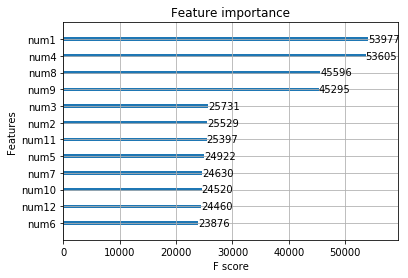

In [12]:
_ = plot_importance(rso_model)

#### Eli5/Tree Interpreter variable importance

In [13]:
eli5.show_weights(rso_model)

Weight,Feature
0.2075,num9
0.1685,num1
0.1667,num4
0.1347,num8
0.0411,num6
0.0408,num2
0.0407,num11
0.0404,num7
0.0402,num10
0.0398,num12


#### Shapley variable importance

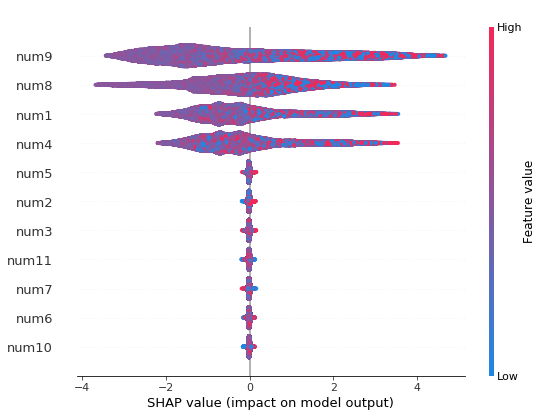

In [14]:
shap_values = rso_model.predict(rsotrain_dm, pred_contribs=True)
shap.summary_plot(shap_values[:, :-1], rsotrain_pd[rso_model.feature_names])

# Model Visualizations: Decision Tree Surrogates, Partial Dependence, and Individual Conditional Expectation

***

#### Function for calculating partial dependence

In [16]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

#### Calculate partial dependence for the most important input variables in the GBM

In [17]:
par_dep_num9 = par_dep('num9', rsotrain_pd[X], rso_model)

In [18]:
par_dep_num9

,num9,partial_dependence
0,-4.543606,0.877914
1,-4.108132,0.877914
2,-3.672657,0.877914
3,-3.237182,0.877914
4,-2.801708,0.877419
5,-2.366233,0.836486
6,-1.930758,0.791394
7,-1.495284,0.691330
8,-1.059809,0.492674
9,-0.624335,0.228526


#### Bind XGBoost predictions to training data

In [19]:
rso_preds = pd.DataFrame(rso_model.predict(rsotrain_dm))

In [20]:
rso_decile_frame = pd.concat([rsotrain_pd, rso_preds], axis=1)
rso_decile_frame = rso_decile_frame.rename(columns={0: 'predict'})
rso_decile_hframe = h2o.H2OFrame(rso_decile_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [21]:
rso_decile_frame.head()

,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,cat1,cat2,cat3,target,row_id,function,predict
0,-0.204708,0.478943,-0.519439,-0.555730,1.965781,1.393406,0.092908,0.281746,0.769023,1.246435,1.007189,-1.296221,AAAAAAAA,AAAAAAAA,GGGGGGGG,0,0,1,0.024664
1,0.274992,0.228913,1.352917,0.886429,-2.001637,-0.371843,1.669025,-0.438570,-0.539741,0.476985,3.248944,-1.021228,GGGGGGGG,CCCCCCCC,BBBBBBBB,0,1,1,0.030679
2,-0.577087,0.124121,0.302614,0.523772,0.000940,1.343810,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757,0.560145,EEEEEEEE,BBBBBBBB,CCCCCCCC,1,2,1,0.970210
3,-1.265934,0.119827,-1.063512,0.332883,-2.359419,-0.199543,-1.541996,-0.970736,-1.307030,0.286350,0.377984,-0.753887,AAAAAAAA,GGGGGGGG,CCCCCCCC,1,3,1,0.841358
4,0.331286,1.349742,0.069877,0.246674,-0.011862,1.004812,1.327195,-0.919262,-1.549106,0.022185,0.758363,-0.660524,DDDDDDDD,AAAAAAAA,DDDDDDDD,1,4,1,0.974320


#### Find percentiles of XGBoost predictions

In [22]:
rso_percentile_dict = ds_.get_percentile_dict('predict', 'row_id', rso_decile_hframe)

In [23]:
rso_percentile_dict

{0: 112984,
 10: 5408,
 20: 47810,
 30: 4505,
 40: 22018,
 50: 131862,
 60: 57714,
 70: 36023,
 80: 186847,
 90: 90718,
 99: 165723}

#### Calculate ICE curve values

In [24]:
# retreive bins from original partial dependence calculation
bins_num9 = list(par_dep_num9['num9'])

# for each percentile in percentile_dict
# create a new column in the par_dep frame 
# representing the ICE curve for that percentile
# and the variables of interest
for i in sorted(rso_percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves for num11 across percentiles at bins_num11 intervals
    par_dep_num9[col_name] = par_dep('num9', 
                                     rsotrain_pd[rsotrain_pd['row_id'] == int(rso_percentile_dict[i])][X], 
                                     rso_model, 
                                     bins=bins_num9)['partial_dependence']


#### Display partial dependence and ICE for num9

In [25]:
par_dep_num9

,num9,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-4.543606,0.877914,0.222158,0.953605,0.979640,0.962898,0.969213,0.953982,0.970400,0.917211,0.970465,0.978771,0.988330
1,-4.108132,0.877914,0.222158,0.953605,0.979640,0.962898,0.969213,0.953982,0.970400,0.917211,0.970465,0.978771,0.988330
2,-3.672657,0.877914,0.222158,0.953605,0.979640,0.962898,0.969213,0.953982,0.970400,0.917211,0.970465,0.978771,0.988330
3,-3.237182,0.877914,0.222158,0.953605,0.979640,0.962898,0.969213,0.953982,0.970400,0.917211,0.970465,0.978771,0.988330
4,-2.801708,0.877419,0.205438,0.953610,0.979965,0.963807,0.969287,0.956065,0.970398,0.918817,0.971569,0.979227,0.988680
5,-2.366233,0.836486,0.067825,0.945218,0.977952,0.959119,0.962398,0.949704,0.968694,0.893356,0.970671,0.978056,0.988566
6,-1.930758,0.791394,0.038711,0.937578,0.973602,0.951096,0.962250,0.923709,0.964309,0.826558,0.964631,0.975331,0.986989
7,-1.495284,0.691330,0.030706,0.701657,0.964471,0.919492,0.944628,0.846791,0.960454,0.295488,0.907257,0.973540,0.977429
8,-1.059809,0.492674,0.017862,0.048986,0.884641,0.848451,0.458253,0.590786,0.945934,0.040225,0.165012,0.964811,0.938410
9,-0.624335,0.228526,0.007652,0.011964,0.038322,0.052942,0.026939,0.173210,0.205186,0.015800,0.020438,0.202750,0.952811


#### Plot partial dependence and ICE

In [26]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)


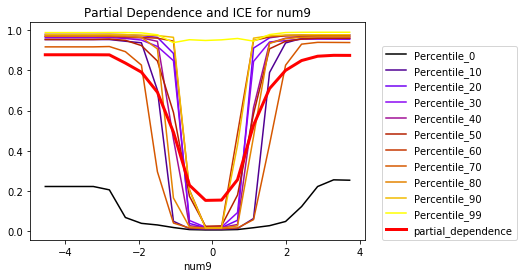

In [27]:
plot_par_dep_ICE('num9', par_dep_num9)

#### Train single h2o decision tree

In [28]:
model_id = 'dt_surrogate_mojo' # gives MOJO artifact a recognizable name

# initialize single tree surrogate model
surrogate = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                     sample_rate=1,     # use all rows in that tree
                                     mtries=-2,         # use all columns in that tree
                                     max_depth=3,       # shallow trees are easier to understand
                                     seed=12345,        # random seed for reproducibility
                                     model_id=model_id) # gives MOJO artifact a recognizable name

# train single tree surrogate model
surrogate.train(x=X, y='predict', training_frame=rso_decile_hframe)

# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')
print('Generated MOJO path:\n', mojo_path)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /home/patrickh/workspace/mli-resources/lime_shap_treeint_compare/dt_surrogate_mojo.zip


#### Create GraphViz dot file

In [29]:
# title for plot
title = 'Known Signal Data (Training Data Only) Decision Tree Surrogate'  

# locate h2o jar
hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

# construct command line call to generate graphviz version of 
# surrogate tree see for more information: 
# http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)
if title is not None:
    gv_args = gv_args + ['--title', title]
    
# call 
print()
print('Calling external process ...')
print(' '.join(gv_args))
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/patrickh/workspace/mli-resources/lime_shap_treeint_compare/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Known Signal Data (Training Data Only) Decision Tree Surrogate


#### Create PNG from GraphViz dot file and display

In [30]:
# construct call to generate PNG from 
# graphviz representation of the tree
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

# call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


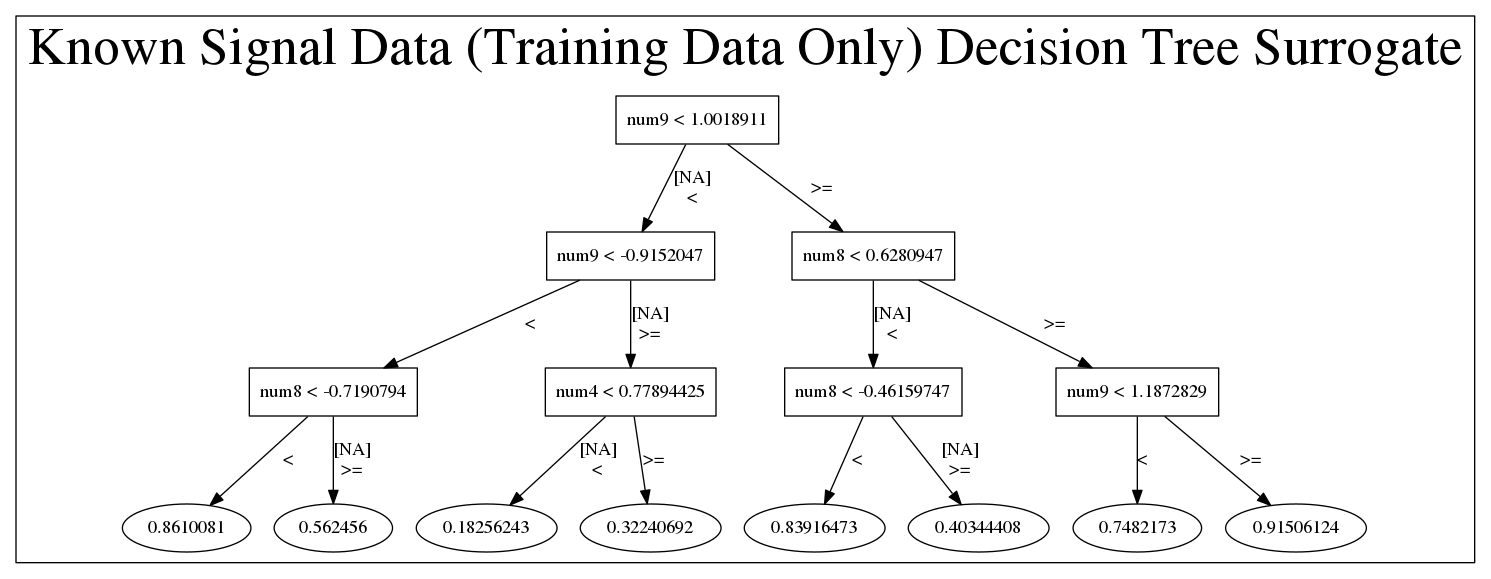

In [31]:
# display in-notebook
display(Image((png_file_name)))

# Local Explanations (variable importance) at Several Percentiles of Model Predictions

***

#### Utility function that displays the TreeInterpreter plot at the chosen decile 

In [32]:
def eli5_dd(decile):
    row = rso_decile_frame[rso_decile_frame['row_id'] == rso_percentile_dict[decile]]
    eli5_df = eli5.explain_prediction_df(rso_model, row[X].iloc[0]).sort_values(by='weight', ascending=True)
    _ = eli5_df[['feature', 'weight']].plot(kind='bar', title='Approximate Local Contributions', x='feature', legend=False)
    return eli5.explain_prediction_xgboost(rso_model, row[X].iloc[0])

#### Utility function that displays the LIME result at the choosen decile

In [33]:
# learn what to discretize from var imp 
# explainer = LIMEExplainer(training_frame=rsotrain_pd, X=X, model=rso_model, discretize=['num1', 'num4', 'num8', 'num9'])
explainer = LIMEExplainer(training_frame=rsotrain_pd, X=X, model=rso_model)

def lime(decile):
    row = rso_decile_frame[rso_decile_frame['row_id'] == rso_percentile_dict[decile]]
    explainer.explain(row.index[0]) 

#### Utility function that displayes the Shapley results at the chosen decile

In [34]:
def shapley(row):
    s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(12, 1), columns=['Approximate Local Contributions'], index=X)
    s_df = s_df.sort_values(by='Approximate Local Contributions')
    print(s_df, '\n')
    _= s_df.plot(kind='bar', title='Approximate Local Contributions', legend=False)
    print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
    p = row['predict'].values[0]
    print('Model prediction: ', np.log(p/(1 - p)))

##  10th decile of model predictions

In [36]:
decile = 10
row = rso_decile_frame[rso_decile_frame['row_id'] == rso_percentile_dict[decile]]

### Shapley values

       Approximate Local Contributions
num9                         -1.255306
num8                         -0.919766
num4                         -0.838739
num1                         -0.805416
num12                        -0.031910
num7                         -0.030496
num6                         -0.022891
num5                         -0.018022
num3                         -0.014298
num11                        -0.003438
num10                         0.011688
num2                          0.045414 

Shapley sum:  -4.330179
Model prediction:  -4.33018399532201


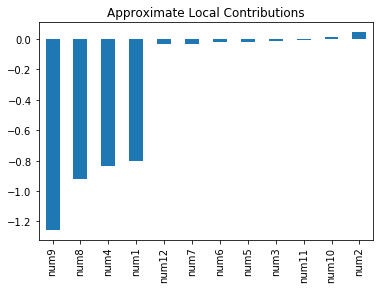

In [37]:
shapley(row)

### TreeInterpreter

Explanation(estimator='<xgboost.core.Booster object at 0x7faa3eba4358>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.11009547677936574, std=None, value=1.0), FeatureWeight(feature='num10', weight=0.05981822814189096, std=None, value=-1.8349747977392599), FeatureWeight(feature='num2', weight=0.0464466879391236, std=None, value=1.6565872903756669), FeatureWeight(feature='num11', weight=0.0068479525371412915, std=None, value=-0.6696070947309072)], neg=[FeatureWeight(feature='num1', weight=-1.0859327423969525, std=None, value=-0.2104105770861187), FeatureWeight(feature='num4', weight=-1.0676122932843293, std=None, value=0.2088497640628786), FeatureWeight(feature='num8', weight=-0.9193736733324612, std=None, value=0.4292748366746852), FeatureWeight(feature='num9', weight=-0.6973393774598918, std=None, value=-0.673427419384263), FeatureWeight(feature='num12', weight=-0.07894436286383034, std=None, value=0.3584526556022754), FeatureWeight(feature='num7', weight=-0.06954033899481309, std=None, value=0.5803070109924322), FeatureWeight(feature='num5', weight=-0.053094884589571456, std=None, value=0.5439712024711477), FeatureWeight(feature='num6', weight=-0.01833448844413863, std=None, value=0.5461287350108828), FeatureWeight(feature='num3', weight=-0.00612452703153124, std=None, value=-0.8192309564523247)], pos_remaining=0, neg_remaining=0), proba=None, score=-3.773088342999999, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

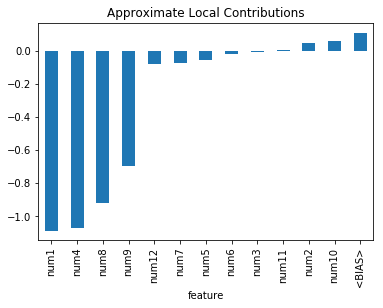

In [38]:
eli5_dd(decile)

In [39]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  -4.33018399532201


### LIME


Model Prediction: 0.01
Local GLM Prediction: -0.02
Local GLM R-square: 0.82
Local GLM Intercept: 0.36

Approximate Local Contributions:
                      Input  Local Contribution
0      num1.(-0.221, 0.459]           -0.124999
1       num4.(0.198, 0.879]           -0.114543
2       num8.(0.419, 1.096]           -0.108604
3   num9.(-0.684, -0.00445]           -0.105280
4                      num3           -0.019648
5                     num10           -0.015471
6                     num11           -0.004274
7                     num12            0.001706
8                      num7            0.006325
9                      num6            0.007060
10                     num5            0.008790
11                     num2            0.089242
None


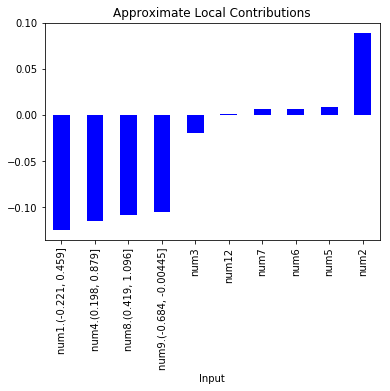

In [40]:
lime(decile)

##  Median of predictions

In [41]:
decile = 50
row = rso_decile_frame[rso_decile_frame['row_id'] == rso_percentile_dict[decile]]

### Shapley values

       Approximate Local Contributions
num9                         -1.625877
num8                         -0.736174
num4                         -0.657797
num2                         -0.046784
num3                         -0.043870
num5                         -0.029267
num10                        -0.027733
num6                         -0.027217
num11                        -0.018977
num7                         -0.001509
num12                         0.004609
num1                          0.802002 

Shapley sum:  -2.8555944
Model prediction:  -2.855602716673076


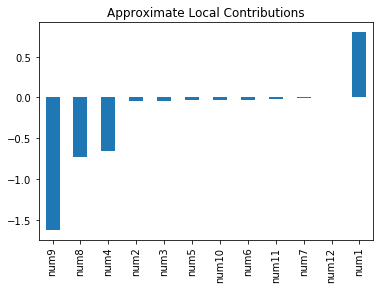

In [42]:
shapley(row)

### TreeInterpreter 

Explanation(estimator='<xgboost.core.Booster object at 0x7faa3eba4358>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num1', weight=0.3941678848137213, std=None, value=-1.2485424082687273), FeatureWeight(feature='<BIAS>', weight=0.11009547677936574, std=None, value=1.0), FeatureWeight(feature='num12', weight=0.07908684053341955, std=None, value=-1.5613650259942164), FeatureWeight(feature='num7', weight=0.008443752336761494, std=None, value=0.5682098378345533), FeatureWeight(feature='num11', weight=0.0027828107364840553, std=None, value=1.9552017314676065)], neg=[FeatureWeight(feature='num9', weight=-1.4958721180848213, std=None, value=0.465221044271343), FeatureWeight(feature='num8', weight=-0.6185455364413729, std=None, value=0.3436797994984805), FeatureWeight(feature='num4', weight=-0.39504747315423266, std=None, value=-0.43683107841698016), FeatureWeight(feature='num2', weight=-0.1078443616610826, std=None, value=-0.13662037258083276), FeatureWeight(feature='num3', weight=-0.10329300924721212, std=None, value=-1.0858458891529243), FeatureWeight(feature='num10', weight=-0.08275039979753877, std=None, value=0.06856495934494355), FeatureWeight(feature='num5', weight=-0.06898688226871345, std=None, value=-1.1587575384245474), FeatureWeight(feature='num6', weight=-0.020744664244779224, std=None, value=0.370814860182257)], pos_remaining=0, neg_remaining=0), proba=None, score=-2.2985076797000006, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

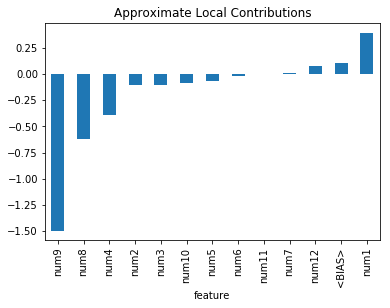

In [43]:
eli5_dd(decile)

In [44]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  -2.855602716673076


### LIME


Model Prediction: 0.05
Local GLM Prediction: 0.23
Local GLM R-square: 0.69
Local GLM Intercept: 0.81

Approximate Local Contributions:
                   Input  Local Contribution
0  num1.(-1.259, -0.579]           -0.149836
1   num4.(-0.447, 0.233]           -0.141901
2     num8.(0.333, 1.01]           -0.139315
3    num9.(0.455, 1.134]           -0.138263
4                   num2           -0.002573
5                   num3           -0.001478
6                   num5           -0.000036
None


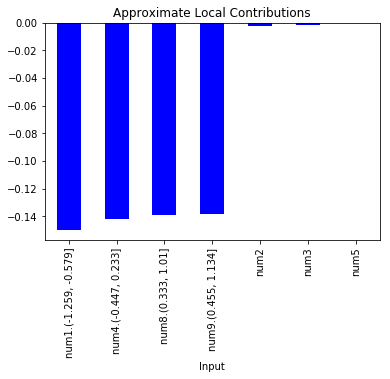

In [45]:
lime(decile)

##  90th decile of model predictions

In [46]:
decile = 90
row = rso_decile_frame[rso_decile_frame['row_id'] == rso_percentile_dict[decile]]

### Shapley values

       Approximate Local Contributions
num1                         -0.296549
num4                         -0.158241
num6                         -0.011366
num2                         -0.004610
num3                         -0.000336
num10                         0.004207
num12                         0.012222
num11                         0.012222
num7                          0.012714
num5                          0.022616
num9                          1.683879
num8                          2.357543 

Shapley sum:  3.187302
Model prediction:  3.1873048702215376


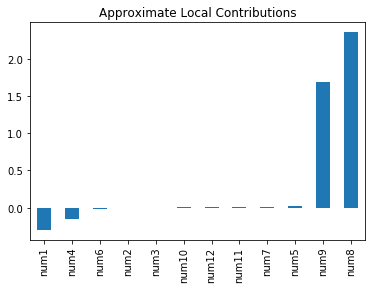

In [47]:
shapley(row)

### TreeInterpreter

Explanation(estimator='<xgboost.core.Booster object at 0x7faa3eba4358>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num8', weight=2.006898337390074, std=None, value=1.7442975830376088), FeatureWeight(feature='num9', weight=0.8200118373579391, std=None, value=-1.0227182709512042), FeatureWeight(feature='num1', weight=0.3986637725668553, std=None, value=0.008450624280560412), FeatureWeight(feature='num4', weight=0.3053879194264498, std=None, value=-0.2786913615938933), FeatureWeight(feature='<BIAS>', weight=0.11009547677936574, std=None, value=1.0), FeatureWeight(feature='num11', weight=0.06916394311875602, std=None, value=0.44952325129919535), FeatureWeight(feature='num12', weight=0.06648779558855535, std=None, value=-0.6277679928498943), FeatureWeight(feature='num10', weight=0.0278437946056682, std=None, value=-0.11428175216569235), FeatureWeight(feature='num7', weight=0.011037143725810048, std=None, value=-1.2061843095889082)], neg=[FeatureWeight(feature='num5', weight=-0.02370199817346962, std=None, value=-1.9659992788895808), FeatureWeight(feature='num3', weight=-0.02015508124182465, std=None, value=0.21827362860012944), FeatureWeight(feature='num2', weight=-0.015524306344085973, std=None, value=-0.9713316056343482), FeatureWeight(feature='num6', weight=-0.011809953800091744, std=None, value=-0.7362829282699529)], pos_remaining=0, neg_remaining=0), proba=None, score=3.744398681, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

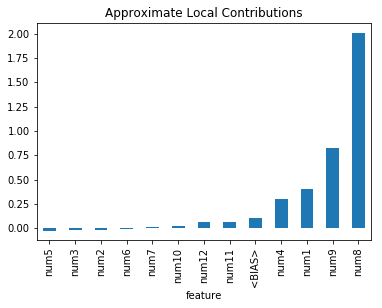

In [48]:
eli5_dd(decile)

In [49]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  3.1873048702215376


### LIME


Model Prediction: 0.96
Local GLM Prediction: 0.57
Local GLM R-square: 0.31
Local GLM Intercept: 0.91

Approximate Local Contributions:
                    Input  Local Contribution
0                    num2           -0.104396
1  num1.(-0.00215, 0.678]           -0.068928
2    num4.(-0.289, 0.391]           -0.054847
3     num8.(1.734, 2.411]           -0.047526
4   num9.(-1.033, -0.354]           -0.043759
5                    num5           -0.018187
6                    num6           -0.001298
7                    num7           -0.000465
8                   num10           -0.000012
9                    num3            0.006703
None


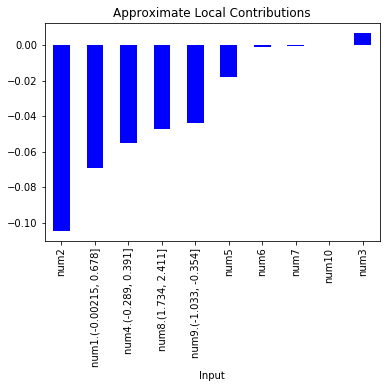

In [50]:
lime(decile)